In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [8]:
engagement = pd.read_csv('takehome_user_engagement.csv', index_col=0)
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [10]:
print('users count: ', engagement['user_id'].nunique())
print('logins count: ', len(engagement))

users count:  8823
logins count:  207917


In [11]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


it looks like we will need to convert the time stamp to a datetime format

In [12]:
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'], format = '%Y-%m-%d %H:%M:%S')
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [25]:
def find_loyal_users(df,days=7,logins=3):
    from datetime import timedelta
    df['date'] = df['time_stamp'].dt.date
    df = df.drop_duplicates(subset='date').sort_values('date')
    passed_days = df['date'].diff(periods=logins-1)
    return any(passed_days <= timedelta(days=days))

loyal_users = engagement.groupby('user_id').apply(find_loyal_users)
loyal_users.name = 'loyal_user'
loyal_users

user_id
1        False
2         True
3        False
4        False
5        False
         ...  
11996    False
11997    False
11998    False
11999    False
12000    False
Name: loyal_user, Length: 8823, dtype: bool

In [17]:
print('Loyal users: ', sum(loyal_users))
print('total users: ', len(loyal_users))

Loyal users:  1656
total users:  8823


-----
users

In [18]:
users = pd.read_csv('takehome_users.csv', encoding = "ISO-8859-1", index_col=0)
users.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
object_id,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [19]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   creation_time               12000 non-null  object 
 1   name                        12000 non-null  object 
 2   email                       12000 non-null  object 
 3   creation_source             12000 non-null  object 
 4   last_session_creation_time  8823 non-null   float64
 5   opted_in_to_mailing_list    12000 non-null  int64  
 6   enabled_for_marketing_drip  12000 non-null  int64  
 7   org_id                      12000 non-null  int64  
 8   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(3), object(4)
memory usage: 937.5+ KB


We will need to clean up the dataset. We will be dropping columns that are unnecessary for modeling and converting the time columns to datetime objects.

In [20]:
users = users.drop(['name','email', 'org_id', 'invited_by_user_id'], axis=1)
users['creation_time'] = pd.to_datetime(users['creation_time'], format='%Y-%m-%d %H:%M:%S')
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   creation_time               12000 non-null  datetime64[ns]
 1   creation_source             12000 non-null  object        
 2   last_session_creation_time  8823 non-null   datetime64[ns]
 3   opted_in_to_mailing_list    12000 non-null  int64         
 4   enabled_for_marketing_drip  12000 non-null  int64         
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 562.5+ KB


In [21]:
#user history, defined as the time between account creation and last login
users['history'] = users['last_session_creation_time'] - users['creation_time']
users['history'] = users['history'].dt.days

#account age, defined as the difference between creation date and the date of assessment (latest account created)
latest = max(users['creation_time'])
users['account_age'] = latest - users['creation_time']
users['account_age'] = users['account_age'].dt.days

#replace two old features with the manipulated features
users = users.drop(['creation_time', 'last_session_creation_time'], axis=1)

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,history,account_age
object_id,,,,,
1,GUEST_INVITE,1,0,0.0,38
2,ORG_INVITE,0,0,136.0,196
3,ORG_INVITE,0,0,0.0,437
4,GUEST_INVITE,0,0,1.0,374
5,GUEST_INVITE,0,0,5.0,498


In [26]:
df = pd.concat([users, loyal_users], axis=1, join='inner')
df['loyal_user'] = df['loyal_user'].astype(int)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'GUEST_INVITE'),
  Text(1, 0, 'ORG_INVITE'),
  Text(2, 0, 'SIGNUP'),
  Text(3, 0, 'PERSONAL_PROJECTS'),
  Text(4, 0, 'SIGNUP_GOOGLE_AUTH')])

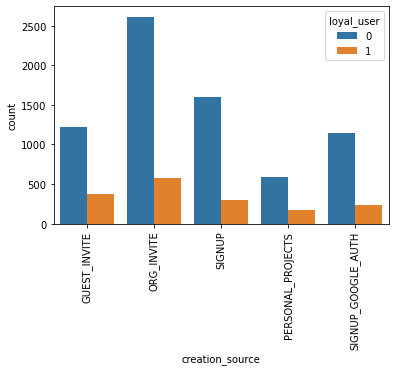

In [31]:
sns.countplot(x='creation_source', data=df, hue='loyal_user')
plt.xticks(rotation=90)

THIS WAS ROUGHLY WHERE I DETERMINED THAT THIS WOULD BE FOR PERSONAL USE ANYWAYS, SO SCREW IT.....

In [34]:
# doesn't look like there was much difference among creation sources
# let's do a chi2 test
from scipy.stats import chi2_contingency
crosstab = pd.crosstab(df['creation_source'], df['loyal_user'])
results = chi2_contingency(crosstab)
print('chi2 = {}\tp = {}'.format(results[0], results[1]))

chi2 = 41.27933208242451	p = 2.3526508745340972e-08


In [36]:
# hmm, chi2 test significant, but how much was the difference
df.groupby('creation_source')['loyal_user'].apply(lambda x: sum(x)/len(x))

creation_source
GUEST_INVITE          0.232368
ORG_INVITE            0.180050
PERSONAL_PROJECTS     0.225131
SIGNUP                0.159115
SIGNUP_GOOGLE_AUTH    0.172563
Name: loyal_user, dtype: float64

OK, slightly higher "adopted user" rate in guest_invite and personal_projects, that makes sense because users who got invite probably was collaborting with others, and users who have personal projects are likely to have more personal interest that make them more engaged.

In [38]:
# check mailing list and marketing drip
df.groupby('opted_in_to_mailing_list')['loyal_user'].apply(lambda x: sum(x)/len(x))

opted_in_to_mailing_list
0    0.185994
1    0.192722
Name: loyal_user, dtype: float64

In [40]:
def z_test(df, col, target='loyal_user'):
    from statsmodels.stats.weightstats import CompareMeans
    opted_in = df.loc[df[col]==1, target]
    opted_out = df.loc[df[col]==0, target]
    z_data = CompareMeans.from_data(opted_in, opted_out)
    z, p = CompareMeans.ztest_ind(z_data)
    print('For {}, z = {}, p = {}'.format(col, z, p))
z_test(df, 'opted_in_to_mailing_list')

For opted_in_to_mailing_list, z = 0.7029779128148211, p = 0.48206951420487776


In [42]:
df.groupby('enabled_for_marketing_drip')['loyal_user'].apply(lambda x: sum(x)/len(x))

enabled_for_marketing_drip
0    0.186982
1    0.191648
Name: loyal_user, dtype: float64

In [43]:
z_test(df, 'enabled_for_marketing_drip')

For enabled_for_marketing_drip, z = 0.40292649500940403, p = 0.6870022995069645


There was really no difference between users who signed up or not for mailing list and marketing drip.

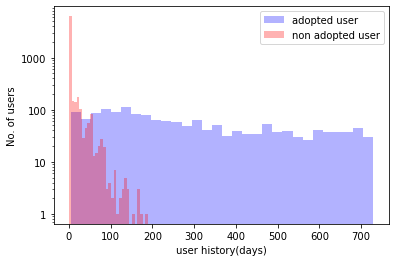

In [44]:
# history and adopted user
def plot_hist_days(df, col, xlabel):
    _ = plt.hist(df.loc[df['loyal_user']==1, col], 
                 bins=30, alpha=0.3, color='b', label='adopted user')
    _ = plt.hist(df.loc[df['loyal_user']==0, col], 
                 bins=30, alpha=0.3, color='r', label='non adopted user')
    _ = plt.yscale('log')
    _ = plt.legend()
    _ = plt.xlabel(xlabel)
    _ = plt.ylabel('No. of users')
    _ = plt.yticks([1, 10, 100, 1000], ['1', '10', '100', '1000'])
plot_hist_days(df, 'history', 'user history(days)')

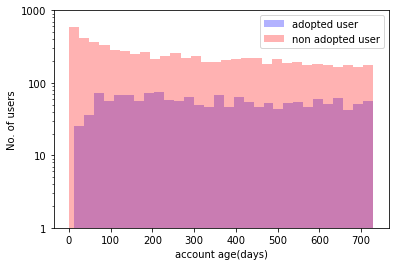

In [46]:
plot_hist_days(df, 'account_age', 'account age(days)')

-------

In [47]:
# make dummy variable for creation source
creation_source = pd.get_dummies(df['creation_source'], drop_first=True)
model_data = pd.concat([df, creation_source], axis=1).drop('creation_source', axis=1)
y = model_data['loyal_user']
X = model_data.drop('loyal_user', axis=1)
# though account_age and history have different scales than other features,
# I plan to use random forest model, which is not affectd by the different scales
# no need to scale the data
# create training and testing sets
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, stratify=y, random_state=42)

In [48]:
# use random forest model with balanced class weights to correct for imbalance in the data
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
clf = RandomForestClassifier(random_state=42, class_weight='balanced')
# use CV to tune number of trees
params = {'n_estimators': [10, 50, 100, 200]}
model = GridSearchCV(clf, params)
model.fit(Xtrain, ytrain)
print('Best parameters were', model.best_params_)
print('Best average precision was', model.best_score_)

Best parameters were {'n_estimators': 200}
Best average precision was 0.9626721517744391


In [49]:
# evluation of the model
from sklearn.metrics import classification_report, accuracy_score
model = RandomForestClassifier(
    random_state=42, class_weight='balanced', n_estimators=200
)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)
print('Accuracy of test set was', accuracy_score(ytest, ypred))
print(classification_report(ytest, ypred))

Accuracy of test set was 0.9510426110607434
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1792
           1       0.88      0.86      0.87       414

    accuracy                           0.95      2206
   macro avg       0.92      0.92      0.92      2206
weighted avg       0.95      0.95      0.95      2206



In [50]:
# take a look at feature importance
imp = pd.Series(model.feature_importances_, index=X.columns)
imp = imp.sort_values(ascending=False)
print(imp)

history                       0.892552
account_age                   0.091526
opted_in_to_mailing_list      0.003301
SIGNUP                        0.003094
enabled_for_marketing_drip    0.002936
ORG_INVITE                    0.002646
PERSONAL_PROJECTS             0.001976
SIGNUP_GOOGLE_AUTH            0.001970
dtype: float64


It is clear that the user history is the most important feature. Based on this, I recommend that an effective way of growing adopted users might be encouraging existing users to log in and use the software after they had accounts for a while.
The next important feature is how user signed up (if you add the importances of the four signup features above). Among the ways they sign up, guest inviation and personal projects are the two categories with highest user adoption rate. Encouraging users to invite others, and offering incentives for people to work on their personal projects using the software might be somewhat effective.
Account age has some importance, but there is nothing can be done to change that.
Mailing list and marketing drip are not effective.